In [1]:
#===============================================================================================
import sys
sys.path.append(r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Synth")
sys.path.append(r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\DAQ")
sys.path.append(r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\API\logs")
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Exceptions')
sys.path.append(r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\HDF5")
sys.path.append(r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\diodo")
#===============================================================================================

import Synthesizer
from diodo import AFG310
from DAQ import DAQ
import json
from Continuous_Acquisition import ACQUISITION_CONFIG
import logging
from logging.config import dictConfig
from logs.logging_config import LOGGING_CONFIG
from Exceptions import replace_non_serializable
import numpy as np
import niscope as ni
import time
import matplotlib.pyplot as plt

In [2]:
#===============================================================================================
#Save acquisition configuration parameters for DAQ configuration
#===============================================================================================

filepath = r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Runs"

#===============================================================================================
#Import logger configuration
#===============================================================================================
dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
logger.info('START EXECUTION')

devicename = 'PXI1Slot4'
sGen_board = ''


try:
    cfg1 = json.dumps(replace_non_serializable(ACQUISITION_CONFIG))
    logger.info('Dumping acquisition configuration')
    with open(ACQUISITION_CONFIG['acq_conf']['path'] + 'config.json','w') as f:
        f.write(cfg1)
except Exception:
    logger.critical('Dumping acquisition configuration')
    raise SystemError("Could not dump acquisition configuration!")

#===============================================================================================
#Acquire DAQ configuration dictionaries
#===============================================================================================

res = 5.345215443088618
sgen_board = ''
amplitude = 0
f = 0

try:
    daq = DAQ()
    logger.info('DAQ class object correctly created')
except Exception:
    logger.critical('Could not crate DAQ class object')
    raise SyntaxError('Could not create DAQ class object')
'''
try:
    s1 = Synthesizer.Synthesizer(1)
    s1.connettore()
    logger.info('Synth class object correctly created and connected!')
except Exception:
    logger.critical('Could not crate synth class object')
    raise SyntaxError('Could not create synth class object')
'''

channels = {'I'			: 0, 
            'Q'			: 3,
            'trigger'	: 0}


try:
    stat = daq.get_status
    logger.info('DAQ status: '+str(stat))
except Exception:
    logger.critical('Could not get DAQ status!')
    raise SystemError('Could not get DAQ status')

try:
    daq.reset_with_def()
    daq.get_status
    logger.info('Resetting DAQ with defaults')
except Exception:
    logger.error('Could not reset DAQ with defaults')
    pass

try:
    daq.acq_conf = ACQUISITION_CONFIG['acq_conf']
    logger.info('Inserting acquisition configuration from ACQUISITION_CONFIG dictionary')
except Exception:
    logger.warning('Coulkd not insert acquisition configuration')
    raise SystemError('Coulkd not insert acquisition configuration')

try:
    daq.horizontal_conf = ACQUISITION_CONFIG['horizontal']
    logger.info('Inserting hconf dic')
except Exception:
    logger.warning('Could not insert hconf dic')
    raise SystemError('Could not insert hconf dic')

try:
    daq.vertical_conf = ACQUISITION_CONFIG['vertical']
    logger.info('Inserting vconf dic')
except Exception:
    logger.warning('Could not insert vconf dic')
    raise SystemError('Could not insert vconf dic')

try:
    daq.chan_conf = ACQUISITION_CONFIG['chan_conf']
    logger.info('Inserting chan char dic')
except Exception:
    logger.warning('Could not insert chan char dic')
    raise SystemError('Could not insert chan char dic')

try:
    daq.trigger_dic = ACQUISITION_CONFIG['trigger']
    logger.info('Inserting trigger dic')
except Exception:
    logger.warning('Could not insert trigger dic')
    raise SystemError('Could not insert trigger dic')

14:07:29.343 - __main__ - <module> - INFO - START EXECUTION
14:07:29.344 - __main__ - <module> - INFO - Dumping acquisition configuration
14:07:29.348 - __main__ - <module> - INFO - DAQ class object correctly created
14:07:29.350 - __main__ - <module> - INFO - DAQ status: <bound method DAQ.get_status of <DAQ.DAQ object at 0x0000000010794CA0>>
14:07:29.351 - __main__ - <module> - ERROR - Could not reset DAQ with defaults
14:07:29.360 - __main__ - <module> - INFO - Inserting acquisition configuration from ACQUISITION_CONFIG dictionary
14:07:29.361 - __main__ - <module> - INFO - Inserting hconf dic
14:07:29.416 - __main__ - <module> - INFO - Inserting vconf dic
14:07:29.417 - __main__ - <module> - INFO - Inserting chan char dic
14:07:29.418 - __main__ - <module> - INFO - Inserting trigger dic


In [3]:
pulser = AFG310()

AFG object created correctly!



In [5]:
#pulser.set_amplitude(1)
pulser.outp_on()
pulser.set_func('SQU')
pulser.set_freq(1e4)
pulser.set_amplitude(1)
pulser.set_offset(0.5)
pulser.trigger_mode()

In [6]:
pulser.execute_trigger()

In [19]:
#===============================================================================================
#GET DATA!
#===============================================================================================

daq._session = ni.Session(devicename)
logger.info('Creating new session!!!')

with daq._session as session:
    logger.info('Configuring channels')
    daq.configure_channels()
    daq.config_trigger()
    I, Q = [], []
    
    for _ in range(10):
        time.sleep(1)
        pulser.execute_trigger()
        daq._session.initiate()
        I.extend(session.channels[0].fetch())
        Q.extend(session.channels[3].fetch())

12:50:00.984 - __main__ - <module> - INFO - Creating new session!!!
12:50:00.985 - __main__ - <module> - INFO - Configuring channels


In [20]:
data = {
    'I': [],
    'Q': []
}
for i in range(len(I)):
    data['I'].extend(I[i].samples.tolist())
    data['Q'].extend(Q[i].samples.tolist())

In [21]:
data['T'] = np.arange(0,len(data['I']),1)

Text(0, 0.5, 'Q signal')

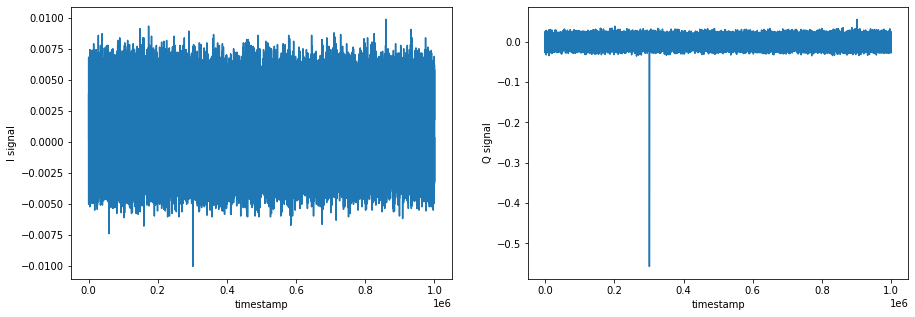

In [22]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(data['T'],data['I'], label='I signal')
axs[1].plot(data['T'],data['Q'], label='Q signal')
axs[0].set_xlabel('timestamp')
axs[0].set_ylabel('I signal')
axs[1].set_xlabel('timestamp')
axs[1].set_ylabel('Q signal')

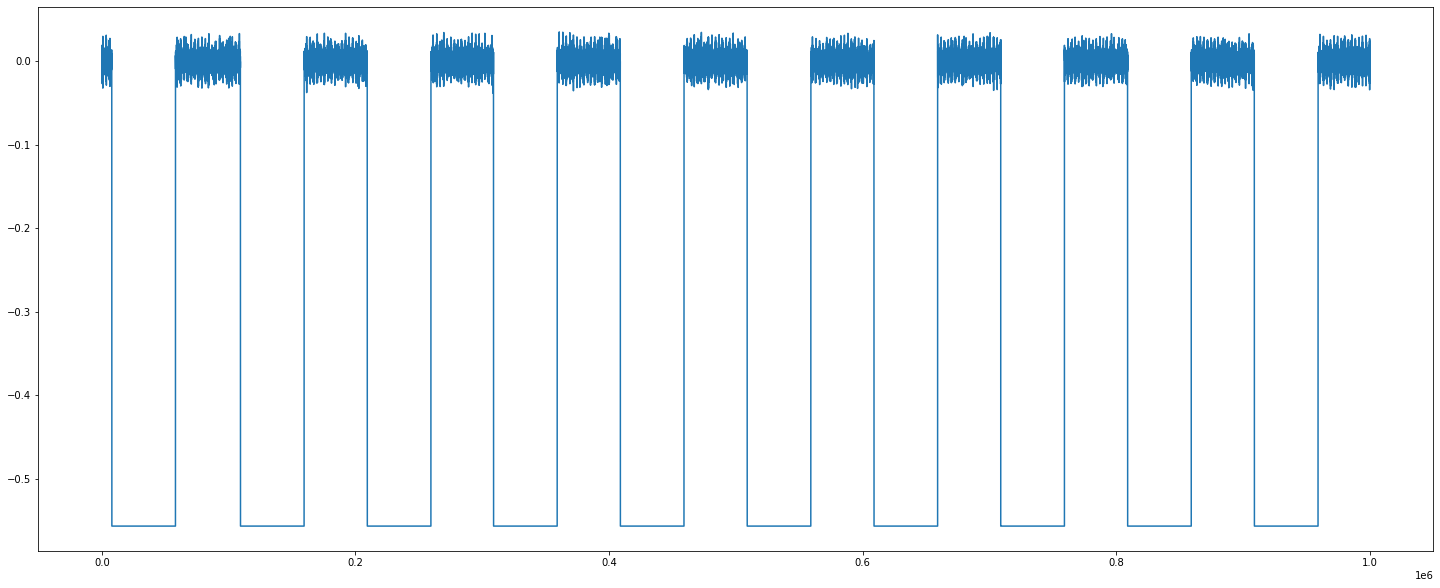

In [14]:
plt.figure(figsize=(25,10))
plt.plot(data['T'],data['Q'])